In [ ]:
#Бойко Дмитрий Алексеевич

In [898]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from prophet import Prophet

## Первичная обработка данных

In [859]:
os.chdir("C:\\Users\\79922\\Downloads\\Data_Science\\ГПН КАП")

In [860]:
df_transaction = pd.read_parquet("transaction_df.parquet")
df_transaction.head()

,product,price,amount,place,datetime
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.9,-0.079689,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00


In [861]:
df_transaction.isna().sum()

product       0
price         0
amount        0
place       432
datetime      0
dtype: int64

In [ ]:
# Формирование датасета о транзакциях, очищенного от пропусков

In [862]:
df_tr_clean = df_transaction[(df_transaction["price"] > 0) & (df_transaction["amount"] > 0)].dropna()

In [863]:
df_tr_clean["date"] = df_tr_clean["datetime"].apply(lambda x: str(x).split(" ")[0])

In [864]:
df_tr_clean.head()

,product,price,amount,place,datetime,date
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00,2216-01-02
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00,2216-01-02
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00,2216-01-02
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00,2216-01-02
6,Целебные травы,3.9,1.736619,Анор Лондо,2216-01-02 11:54:00,2216-01-02


In [865]:
df_weather = pd.read_parquet("weather_df.parquet")
df_weather.head(10)

,place,hot,rain,snow,date
0,Фалькония,0,0,0,2216-01-02
1,Анор Лондо,1,0,0,2216-01-02
2,Врата Балдура,0,0,1,2216-01-02
3,Нокрон,0,0,0,2216-01-02
4,Кеджистан,0,0,1,2216-01-02
5,Фалькония,0,0,1,2216-01-03
6,Анор Лондо,1,0,0,2216-01-03
7,Врата Балдура,0,0,1,2216-01-03
8,Нокрон,0,0,1,2216-01-03
9,Кеджистан,0,0,0,2216-01-03


In [866]:
df_weather.describe()

,hot,rain,snow
count,5000.000000,5000.000000,5000.000000
mean,0.175200,0.172600,0.167200
std,0.380176,0.377939,0.373192
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [867]:
df_weather.isna().sum()

place    0
hot      0
rain     0
snow     0
date     0
dtype: int64

In [868]:
df_competitors = pd.read_parquet("df_competitors.parquet")
df_competitors.head()

,place,product,competitor,price,date
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05
2,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-06
3,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-09
5,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-11


In [869]:
df_competitors.describe()

,price
count,31799.000000
mean,11.894810
std,5.574935
min,2.850000
25%,7.780000
50%,11.050000
75%,15.030000
max,31.940000


In [870]:
df_competitors.isna().sum()

place         0
product       0
competitor    0
price         0
date          0
dtype: int64

In [871]:
df_cost = pd.read_parquet("df_cost.parquet")
df_cost.head()

,place,product,cost,date
0,Анор Лондо,Целебные травы,2.07,2216-01-02
1,Анор Лондо,Целебные травы,3.07,2216-01-26
2,Анор Лондо,Целебные травы,3.30,2216-02-12
3,Анор Лондо,Целебные травы,4.04,2216-03-06
4,Анор Лондо,Целебные травы,3.88,2216-03-27


In [872]:
df_cost.describe()

,cost
count,1117.000000
mean,6.859955
std,3.856876
min,1.180000
25%,3.910000
50%,5.930000
75%,8.860000
max,24.520000


In [ ]:
# Проверка, что разные датасеты содержат одни и те же даты

In [873]:
len(df_tr_clean["date"].value_counts())

1000

In [874]:
len(df_weather["date"].value_counts())

1000

In [875]:
len(df_competitors["date"].value_counts())

1000

In [876]:
set(df_tr_clean["date"].value_counts().index).difference(
    set(df_weather["date"].apply(lambda x: str(x).split(" ")[0]).value_counts().index))

set()

In [877]:
set(df_tr_clean["date"].value_counts().index).difference(
    set(df_competitors["date"].apply(lambda x: str(x).split(" ")[0]).value_counts().index))

set()

In [ ]:
# Дней в датасете о затратах явно меньше, чем в других

In [878]:
len(df_cost["date"].value_counts())

685

In [879]:
places = df_transaction['place'].value_counts().index
products = df_transaction['product'].value_counts().index

In [880]:
place_dict = {places[i]:i for i in range(len(places))}
product_dict = {products[i]:i for i in range(len(products))}

In [881]:
df_cost.head()

,place,product,cost,date
0,Анор Лондо,Целебные травы,2.07,2216-01-02
1,Анор Лондо,Целебные травы,3.07,2216-01-26
2,Анор Лондо,Целебные травы,3.30,2216-02-12
3,Анор Лондо,Целебные травы,4.04,2216-03-06
4,Анор Лондо,Целебные травы,3.88,2216-03-27


In [ ]:
# формирование новых датасетов для каждой пары товар-место с данными по дням, средней ценой и общим спросом в день,
# а также с погодными условиями, средней ценой конкурента и затратами на производство единицы товара в этот день

In [882]:
new_dfs = [[[] for place in places] for product in products]
for (date, product, place), price_amount_df in df_tr_clean.groupby(["date", "product", "place"]):
    row = pd.DataFrame(range(1))
    row["date"] = date
    row["avg price"] = round(price_amount_df["price"].mean(), 2)
    row["avg comp price"] = round(df_competitors[(df_competitors["date"] == date)&(df_competitors["product"] == product)&(
    df_competitors["place"] == place)]["price"].mean(), 2)
    row["hot"] = df_weather[(df_weather["date"] == date)&(df_weather["place"] == place)]["hot"].iloc[0]
    row["rain"] = df_weather[(df_weather["date"] == date)&(df_weather["place"] == place)]["rain"].iloc[0]
    row["snow"] = df_weather[(df_weather["date"] == date)&(df_weather["place"] == place)]["snow"].iloc[0]
    amount = round(price_amount_df["amount"].sum(), 3)
    row["total amount"] = amount
    try:
        cost = df_cost[(df_cost["date"] == date)&(df_cost["product"] == product)&(
    df_cost["place"] == place)]["cost"].iloc[0]
    except:
        cost = 0
    row["cost per unit"] = round(cost / amount, 3)
    new_dfs[product_dict[product]][place_dict[place]].append(row)

In [883]:
df_product_place = [[pd.concat(new_dfs[i][j]).sort_values("date").drop(0, axis = 1).set_index("date") for j in range(len(places))
                    ] for i in range(len(products))]

In [884]:
for product in products:
    for place in places:
        df = df_product_place[product_dict[product]][place_dict[place]]
        di = {0:df[df["cost per unit"] > 0]["cost per unit"].quantile(0.5)}
        df_product_place[product_dict[product]][place_dict[place]]["cost per unit"] = df["cost per unit"].replace(di)

In [76]:
for product in products:
    for place in places:
        print(product, place, df_product_place[product_dict[product]][place_dict[place]].isna().sum().sum())

Эстус Фалькония 41
Эстус Нокрон 56
Эстус Кеджистан 50
Эстус Анор Лондо 39
Эстус Врата Балдура 52
Целебные травы Фалькония 49
Целебные травы Нокрон 46
Целебные травы Кеджистан 47
Целебные травы Анор Лондо 44
Целебные травы Врата Балдура 35
Эльфийская пыльца Фалькония 62
Эльфийская пыльца Нокрон 47
Эльфийская пыльца Кеджистан 50
Эльфийская пыльца Анор Лондо 47
Эльфийская пыльца Врата Балдура 37


In [ ]:
# Датасет для товара "Целебные травы" и места "Анор Лондо"

In [885]:
df_ct_al = df_product_place[product_dict["Целебные травы"]][place_dict["Анор Лондо"]]

In [886]:
df_ct_al.head()

,avg price,avg comp price,hot,rain,snow,total amount,cost per unit
date,,,,,,,
2216-01-02,3.9,4.21,1,0,0,37.803,0.055
2216-01-03,3.9,4.05,1,0,0,43.265,0.113
2216-01-04,3.9,3.98,0,0,0,35.630,0.113
2216-01-05,3.9,3.90,0,0,0,37.474,0.113
2216-01-06,3.9,3.98,0,0,1,48.587,0.113


<Axes: xlabel='date'>

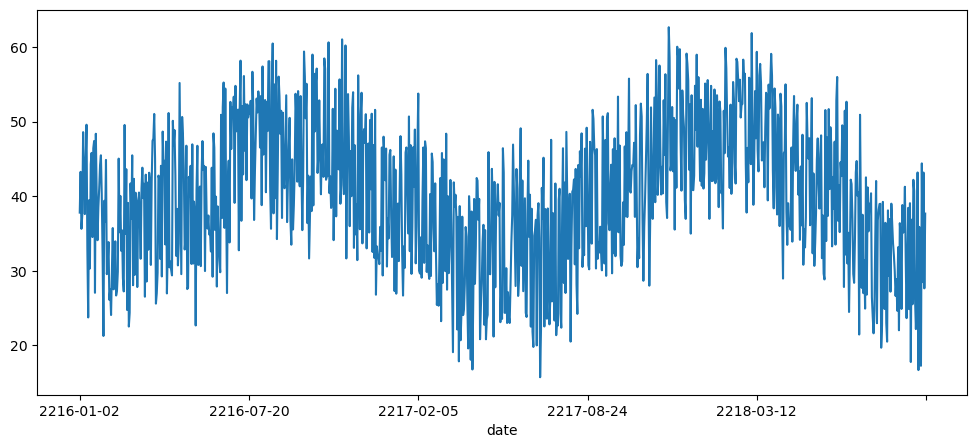

In [887]:
df_ct_al["total amount"].plot()

<Axes: xlabel='date'>

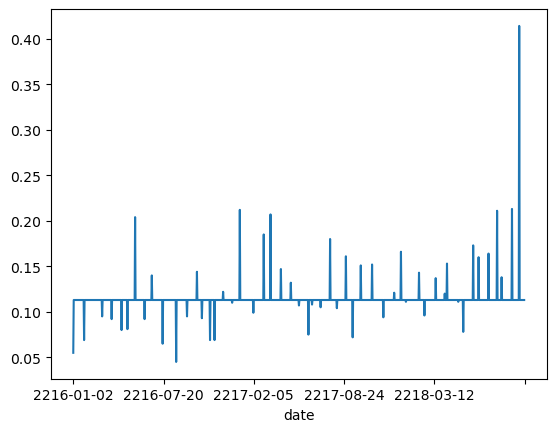

In [89]:
df_ct_al["cost per unit"].plot()

<Axes: xlabel='date'>

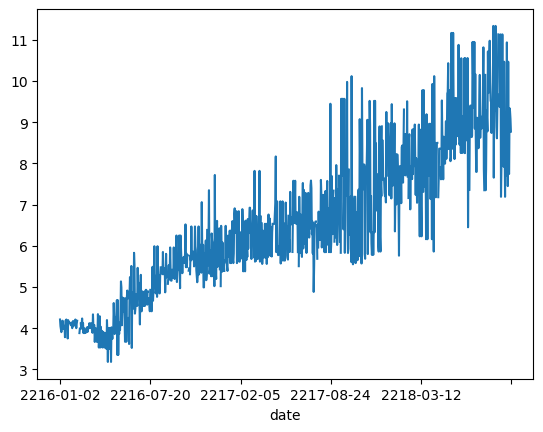

In [32]:
df_ct_al["avg comp price"].plot()

## Выбор и построение моделей прогнозирования

In [ ]:
# Попытки построения модели линейной регрессии для предсказания спроса для товара "Целебные травы" и места "Анор Лондо"

In [510]:
df_ct_al_copy = df_ct_al.copy().reset_index()
df_ct_al_copy['t'] = df_ct_al_copy.index
df_ct_al_copy['t'] = df_ct_al_copy['t'].apply(lambda t: np.pi * 2 / 500 * t)
df_ct_al_copy['cost'] = df_ct_al_copy['t'].apply(np.cos)
df_ct_al_copy['sint'] = df_ct_al_copy['t'].apply(np.sin)
df_ct_al_copy

,date,avg price,avg comp price,hot,rain,snow,total amount,cost per unit,t,cost,sint
0,2216-01-02,3.90,4.210000,1,0,0,37.803,0.055,0.000000,1.000000,0.000000
1,2216-01-03,3.90,4.046667,1,0,0,43.265,0.113,0.012566,0.999921,0.012566
2,2216-01-04,3.90,3.980000,0,0,0,35.630,0.113,0.025133,0.999684,0.025130
3,2216-01-05,3.90,3.903333,0,0,0,37.474,0.113,0.037699,0.999289,0.037690
4,2216-01-06,3.90,3.980000,0,0,1,48.587,0.113,0.050265,0.998737,0.050244
...,...,...,...,...,...,...,...,...,...,...,...
995,2218-09-23,13.63,7.745000,0,1,0,44.401,0.113,12.503539,0.998027,-0.062791
996,2218-09-24,13.63,9.342500,0,0,0,28.491,0.113,12.516105,0.998737,-0.050244
997,2218-09-25,13.63,9.270000,0,0,1,43.173,0.113,12.528672,0.999289,-0.037690
998,2218-09-26,13.63,9.086667,0,0,0,27.653,0.113,12.541238,0.999684,-0.025130


In [312]:
tss = TimeSeriesSplit(n_splits = 5)

In [ ]:
# Построение модели, в которой учитывается фактор средняя цена у конкурентов

In [925]:
X1 = df_ct_al_copy.drop(["date", "total amount"], axis = 1).dropna()
y1 = df_ct_al_copy.dropna()["total amount"]

In [927]:
model1 = LinearRegression()
print(cross_val_score(model1, X1, y1, cv = tss, scoring = "neg_mean_squared_error").mean())
print(cross_val_score(model1, X1, y1, cv = tss, scoring = "neg_mean_absolute_percentage_error").mean())

-263.0809960908535
-0.21051513173380884


In [932]:
model1.fit(X1, y1)

LinearRegression()

In [ ]:
# Видно, что коэффициент при факторе средняя цена у конкурентов значительно меньше по модулю, чем остальные,
# из чего можно предположить, что он не значим

In [933]:
np.round(model1.coef_, 2)

array([ -2.07,   0.2 ,  12.75,  13.16,  13.55, -19.86,   1.09,  -7.27,
        -0.55])

In [ ]:
# Построение модели, в без уча фактора средней цены у конкурентов

In [928]:
X2 = df_ct_al_copy.drop(["date", "total amount", "avg comp price"], axis = 1)
y2 = df_ct_al_copy["total amount"]

In [929]:
model2 = LinearRegression()
print(cross_val_score(model2, X2, y2, cv = tss, scoring = "neg_mean_squared_error").mean())
print(cross_val_score(model2, X2, y2, cv = tss, scoring = "neg_mean_absolute_percentage_error").mean())

-104.85831114724735
-0.15945774192731665


In [915]:
# Качество улучшилось, значит можно сделать вывод, что фактор средняя цена у конкурентов не значим 
#и не использовать его в модели

In [934]:
model2.fit(X2, y2)

LinearRegression()

In [ ]:
# Теперь перед синусом коэффициент по модулю значительно меньше, чем у остальных

In [935]:
model2.coef_

array([ -2.05766323,  12.92728972,  13.14324747,  13.6004018 ,
       -18.86837232,   1.16245554,  -7.27302052,  -0.63983114])

In [ ]:
# Построение модели без синуса

In [930]:
X3 = df_ct_al_copy.drop(["date", "total amount", "avg comp price", "sint"], axis = 1)
y3 = df_ct_al_copy["total amount"]

In [931]:
model3 = LinearRegression()
print(cross_val_score(model3, X3, y3, cv = tss, scoring = "neg_mean_squared_error").mean())
print(cross_val_score(model3, X3, y3, cv = tss, scoring = "neg_mean_absolute_percentage_error").mean())

-30.150543123236275
-0.11395758996693373


In [ ]:
# Результаты стали еще лучше

In [936]:
model3.fit(X3, y3)

LinearRegression()

In [937]:
np.round(model3.coef_, 2)

array([ -1.88,  12.94,  13.13,  13.55, -19.27,   1.11,  -7.32])

In [311]:
model = LinearRegression()

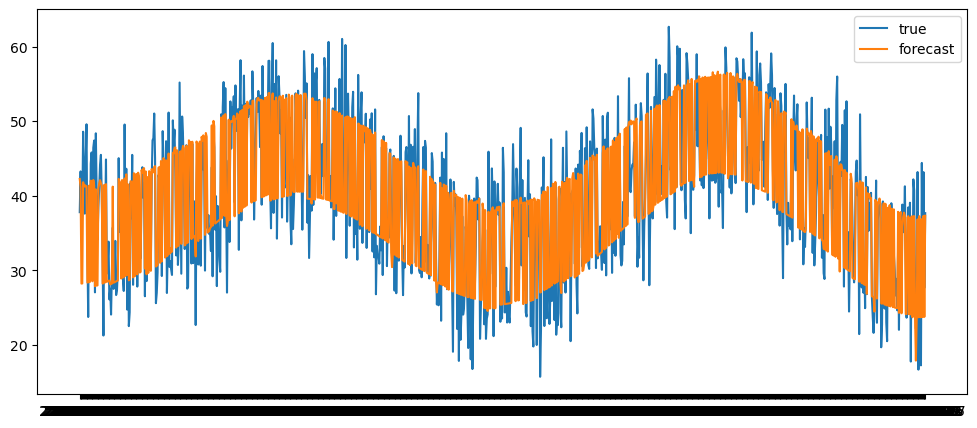

In [938]:
plt.plot(df_ct_al["total amount"], label = "true")
plt.plot(model3.predict(X3), label = "forecast")
plt.legend()

In [ ]:
# Просмотр данных о спросе для каждого датасета
# Временные ряды ведут себя похожим образом

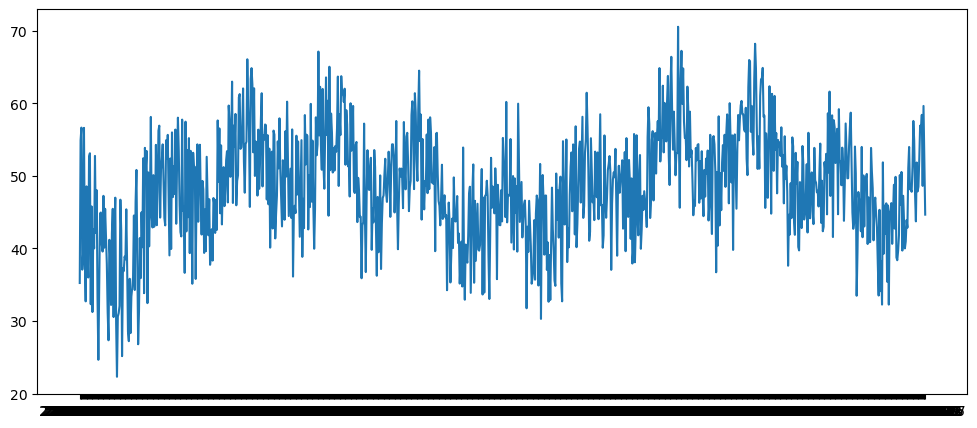

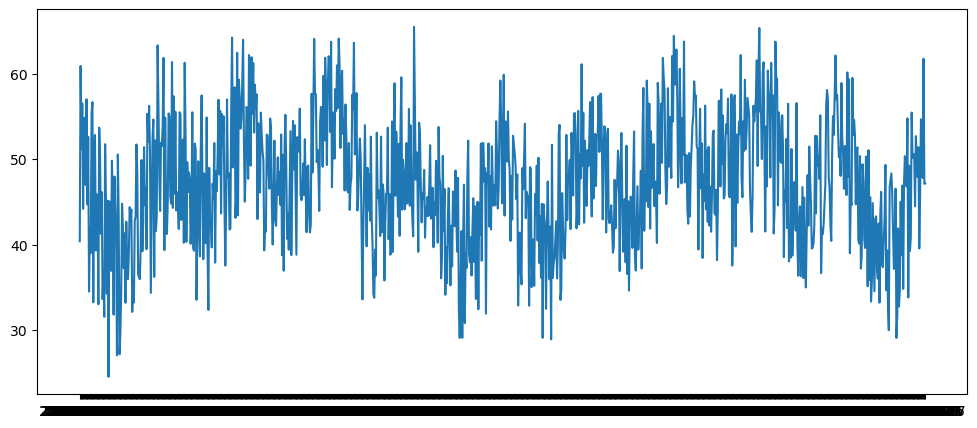

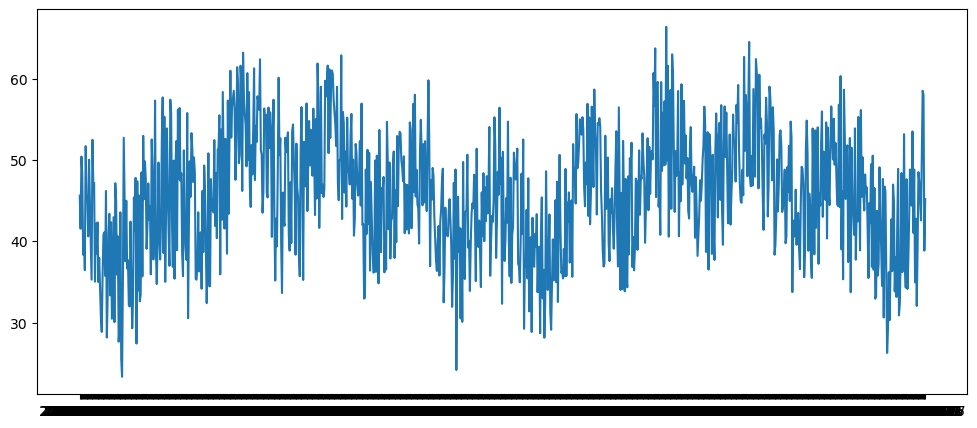

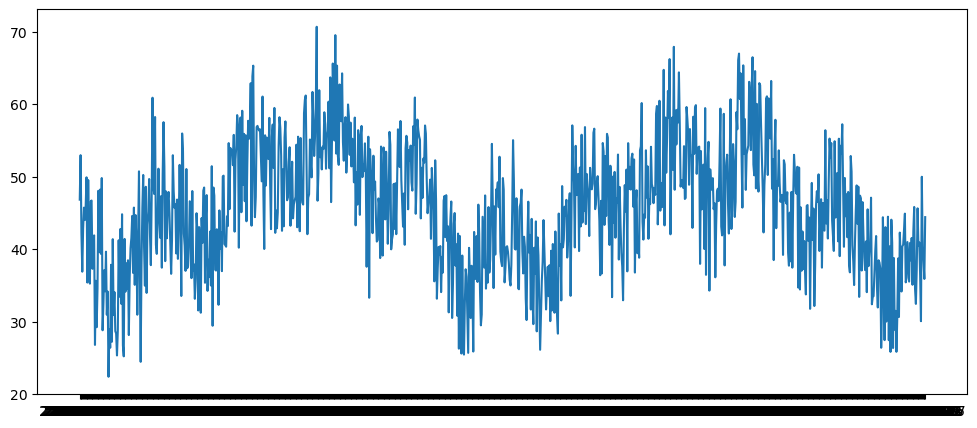

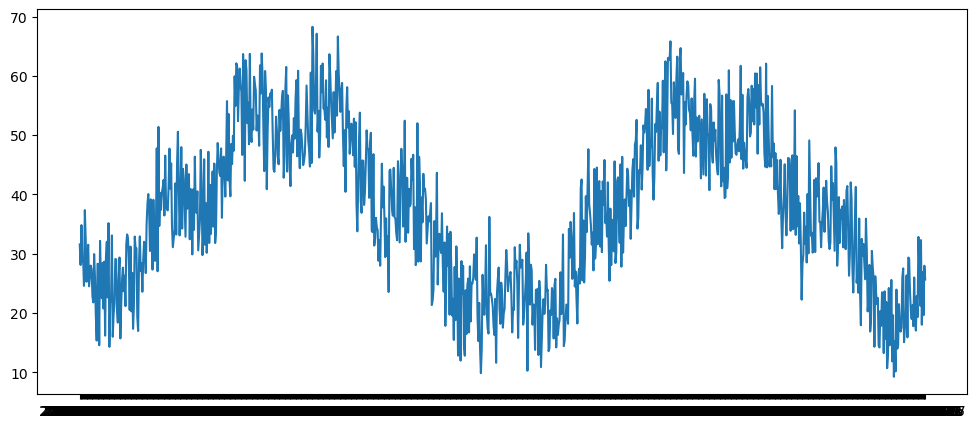

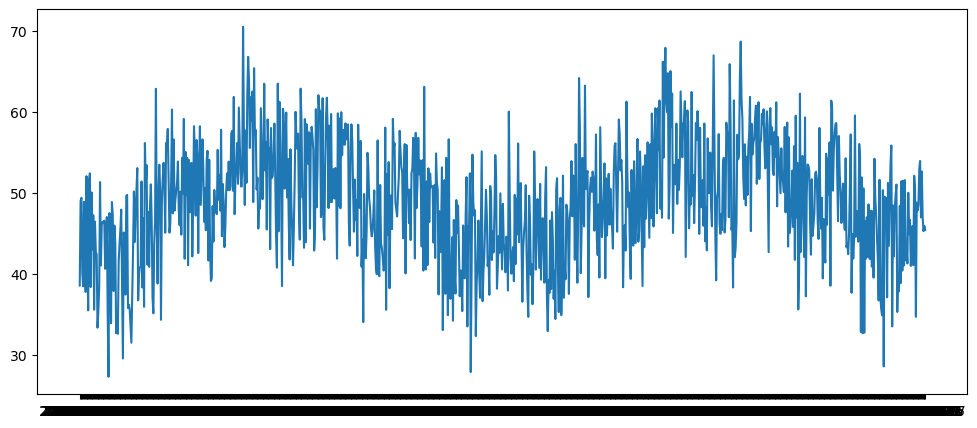

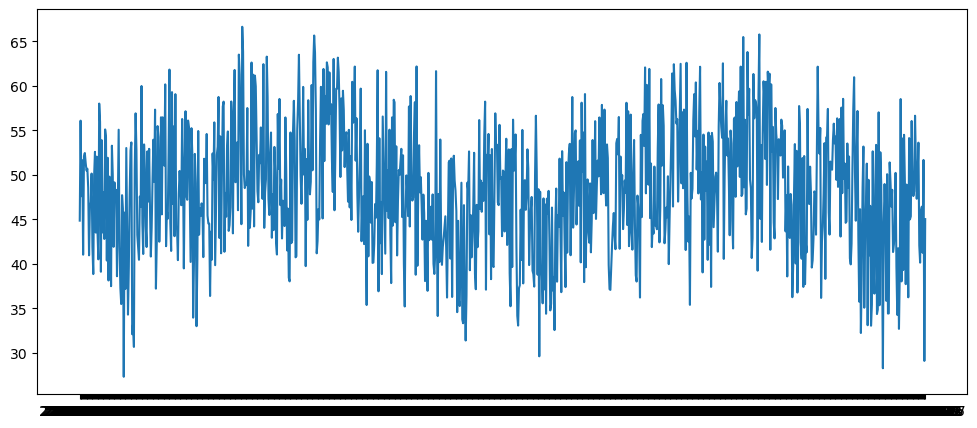

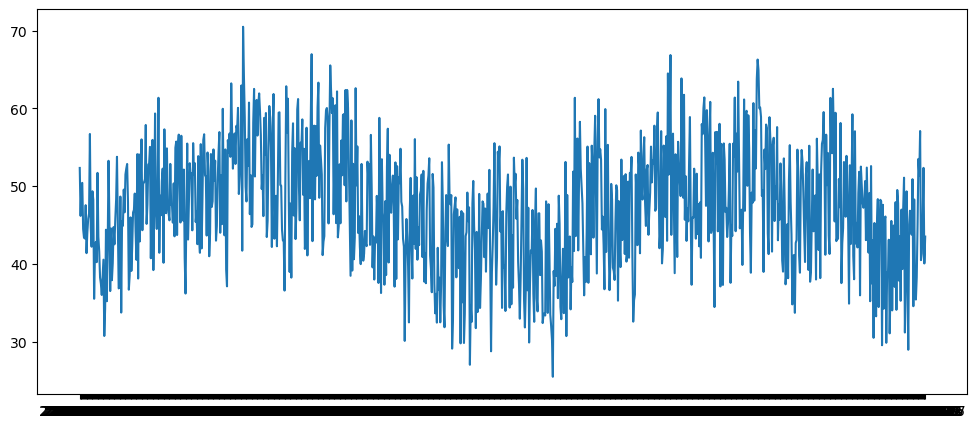

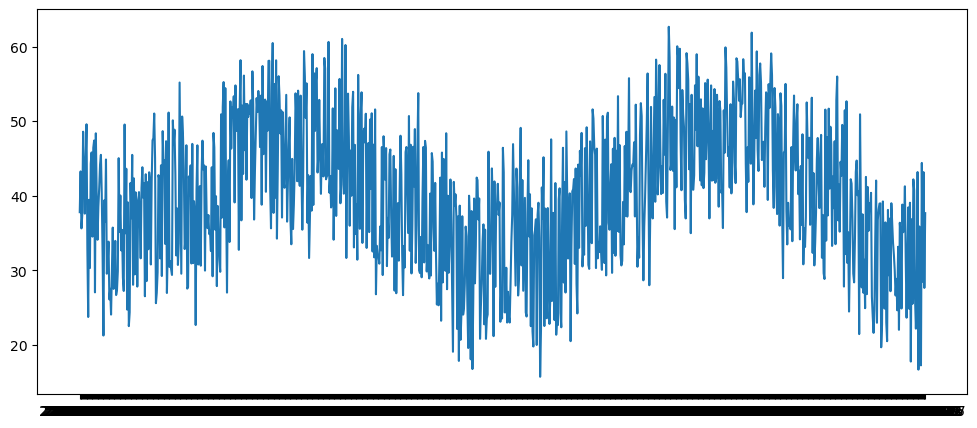

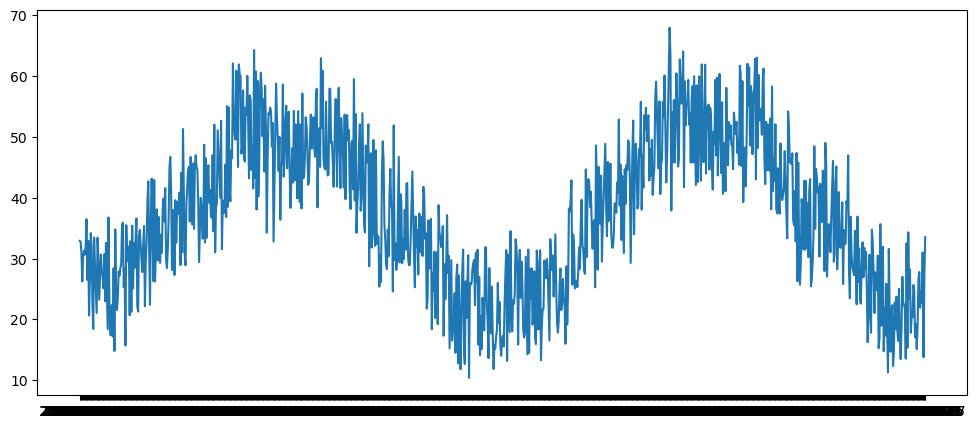

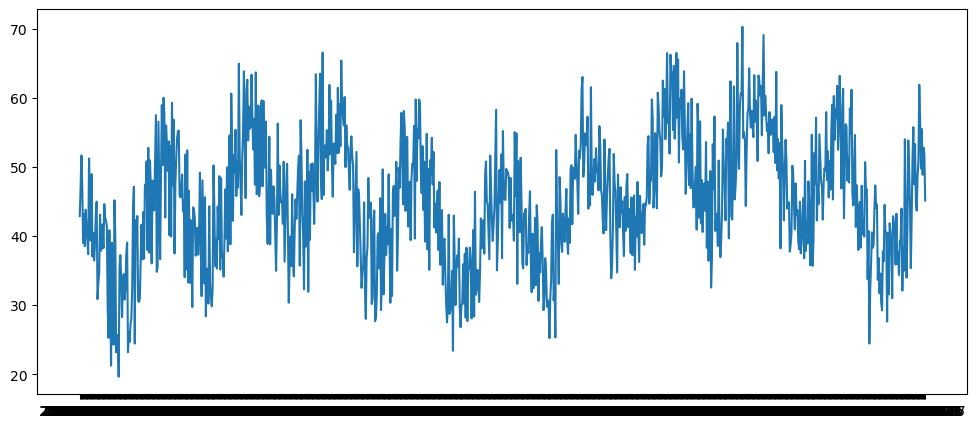

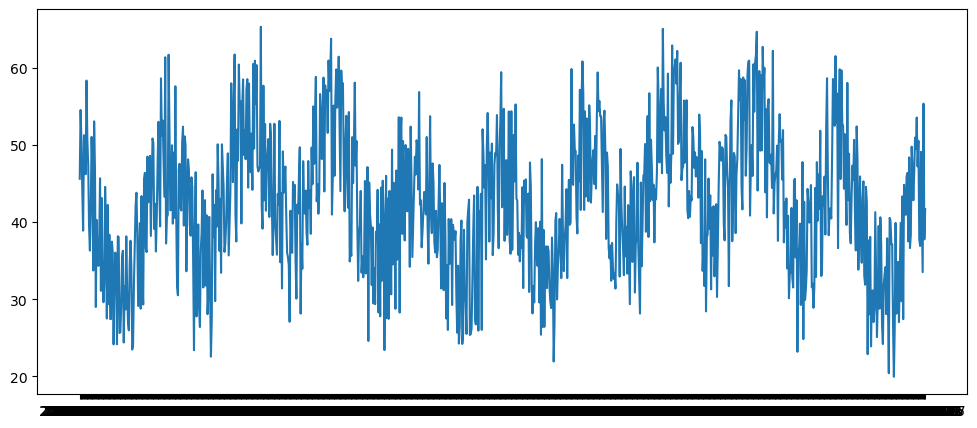

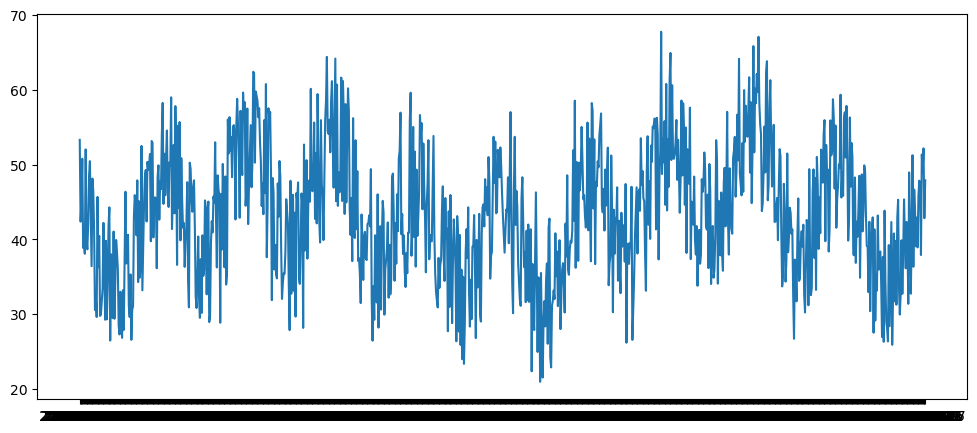

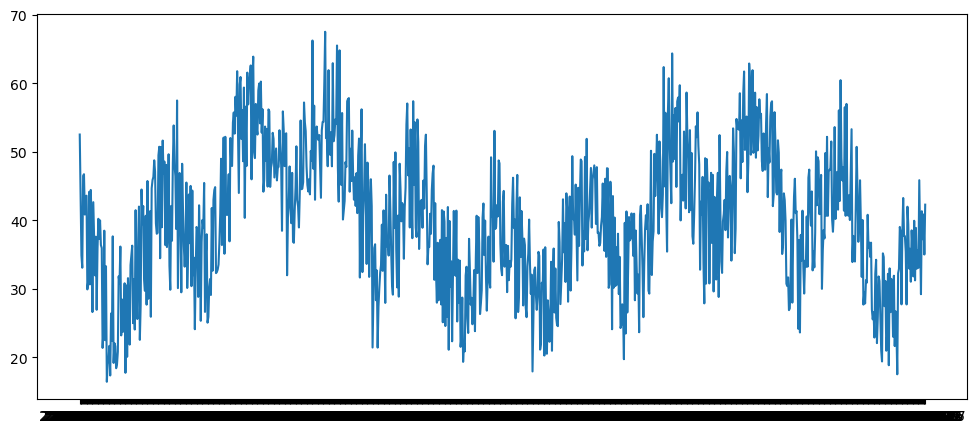

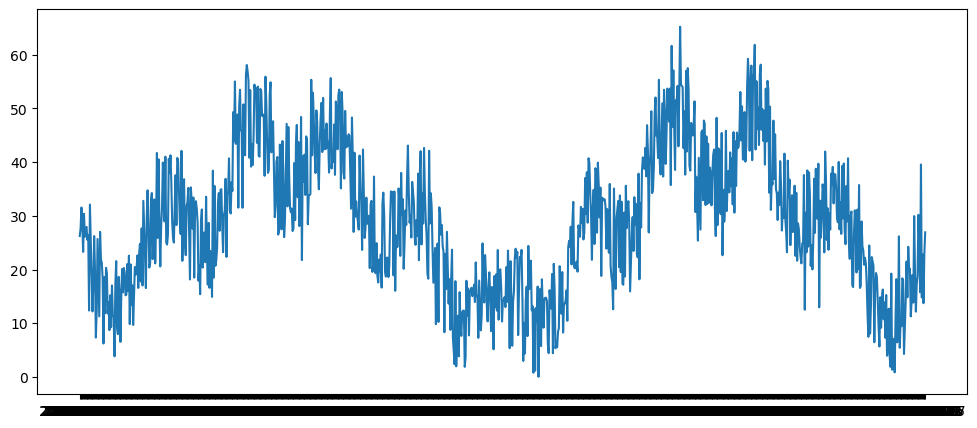

In [899]:
for product in products:
    for place in places:
        fig, ax = plt.subplots()
        ax.plot(df_product_place[product_dict[product]][place_dict[place]]["total amount"])

In [ ]:
# Построение моделей линейной регрессии для прогнозирования спроса по каждому датасету и вывод среденей MAPE на кросс-валидации

In [939]:
models = [[0 for j in range(len(places))] for i in range(len(products))]
for product in products:
    for place in places:
        df = df_product_place[product_dict[product]][place_dict[place]]
        df = df.reset_index()
        df['t'] = df.index
        df['tt'] = df['t'].apply(lambda t: np.pi * 2 / 500 * t)
        df['cost'] = df['tt'].apply(np.cos)
        X = df.drop(["date", "total amount", "avg comp price","tt", "cost per unit"], axis = 1)
        y = df["total amount"]
        tss = TimeSeriesSplit(n_splits = 5)
        model = LinearRegression()
        print("MAPE = "+ str(-cross_val_score(model, X, y, cv = tss, scoring = "neg_mean_absolute_percentage_error").mean()))
        model.fit(X, y)
        models[product_dict[product]][place_dict[place]] = model

MAPE = 0.10598837968286508
MAPE = 0.11012346997900595
MAPE = 0.12421022195105098
MAPE = 0.10377201177431905
MAPE = 0.12655423797754922
MAPE = 0.07968246527742168
MAPE = 0.07658120629489647
MAPE = 0.10068341534255545
MAPE = 0.11386846679895565
MAPE = 0.10864429683512096
MAPE = 0.16933140329830568
MAPE = 0.19624917569140793
MAPE = 0.21450721458837446
MAPE = 0.3066228738032571
MAPE = 0.7727361422581129


In [ ]:
# Просмотр графика для модели с самой низкой MAPE

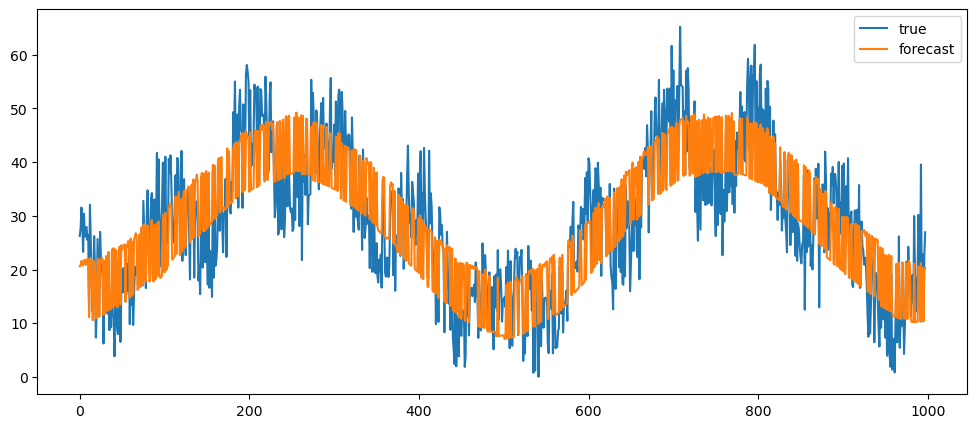

In [892]:
df = df_product_place[product_dict[products[-1]]][place_dict[places[-1]]]
df = df.reset_index()
df['t'] = df.index
df['tt'] = df['t'].apply(lambda t: np.pi * 2 / 500 * t)
df['cost'] = df['tt'].apply(np.cos)
X = df.drop(["date", "total amount", "avg comp price","tt", "cost per unit"], axis = 1)
y = df["total amount"]
model = LinearRegression()
model.fit(X, y)
plt.plot(df["total amount"], label = "true")
plt.plot(model.predict(X), label = "forecast")
plt.legend()

In [ ]:
# Просмотр данных о затратах для каждого датасета

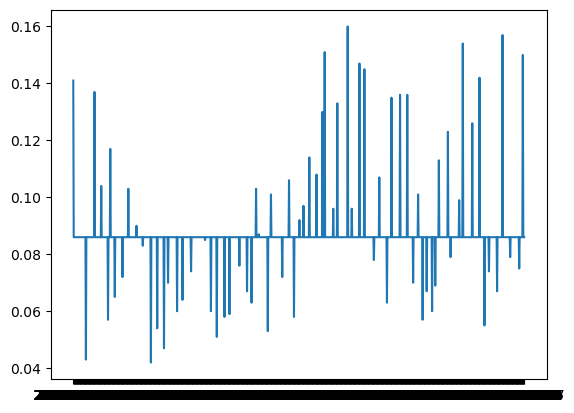

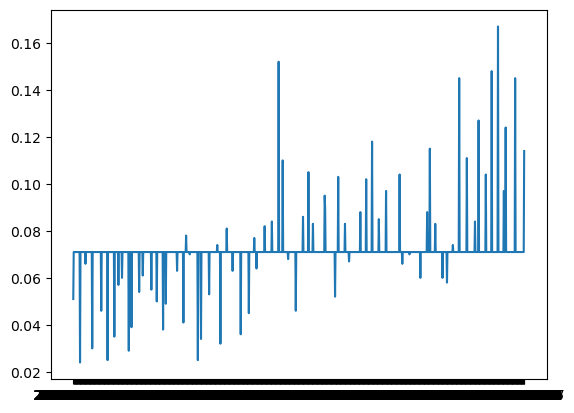

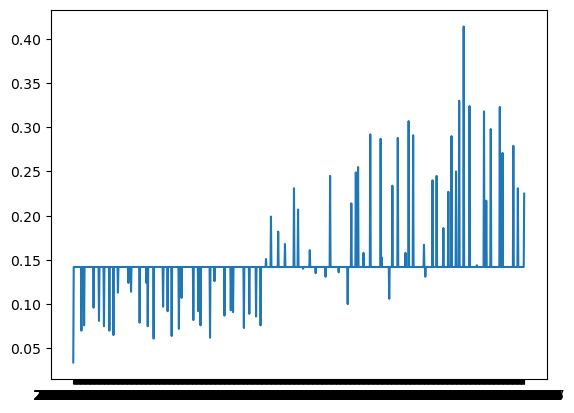

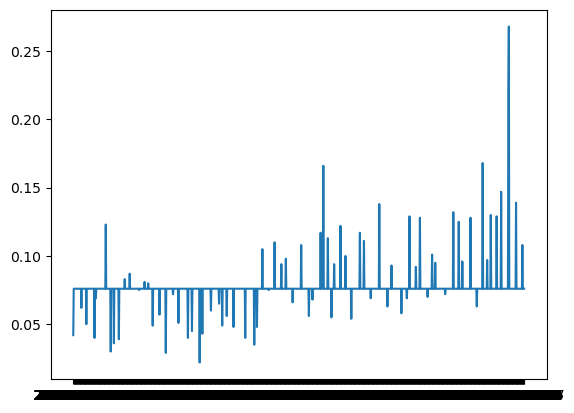

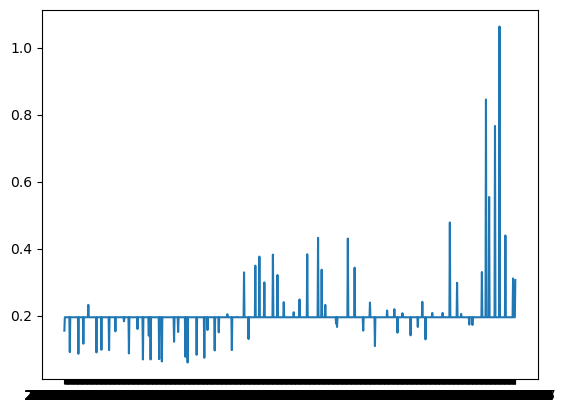

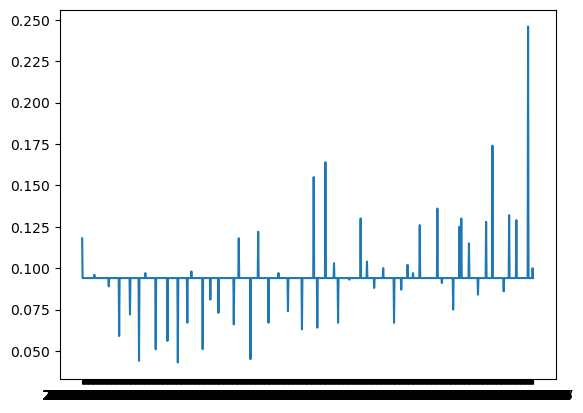

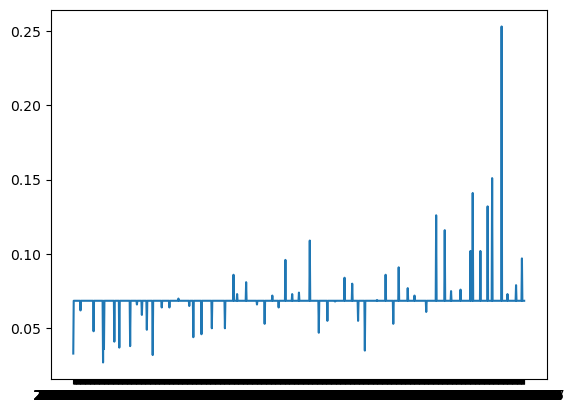

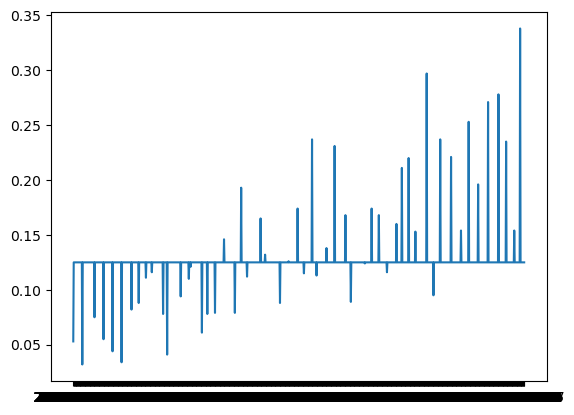

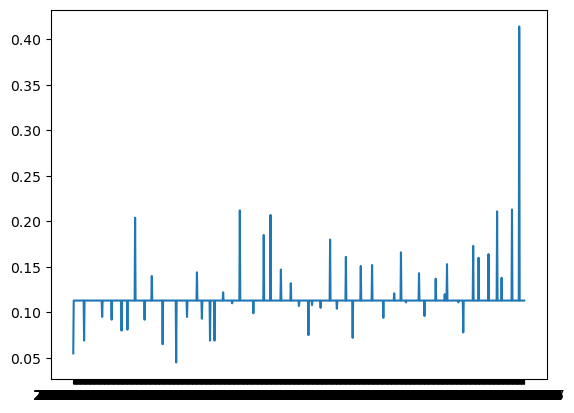

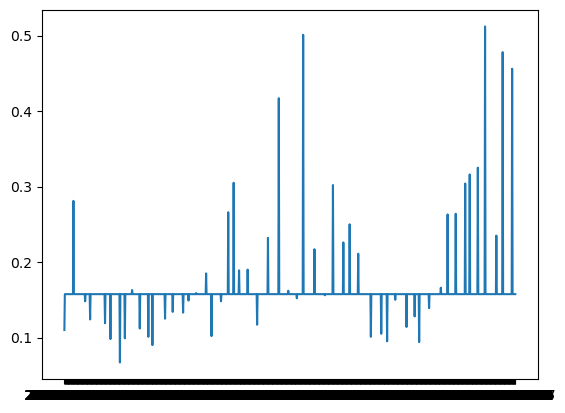

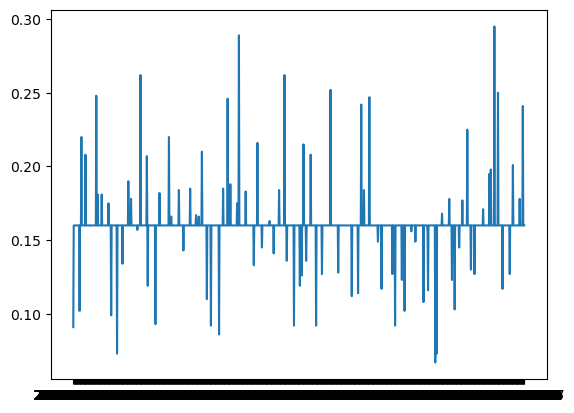

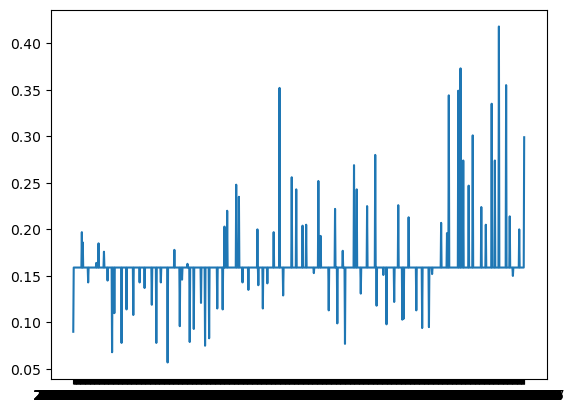

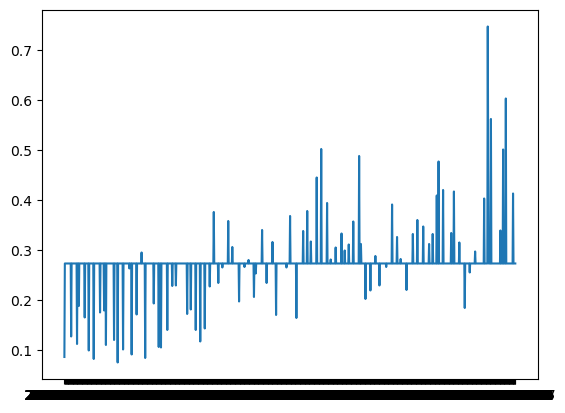

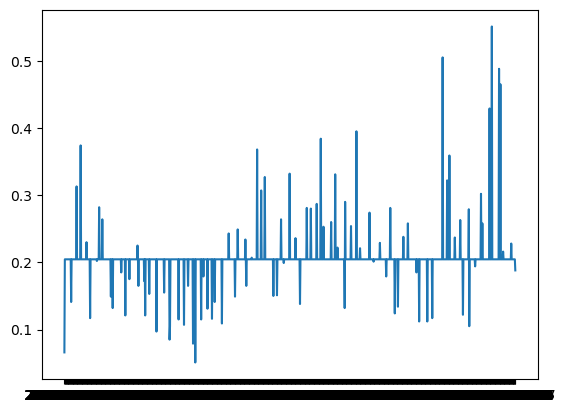

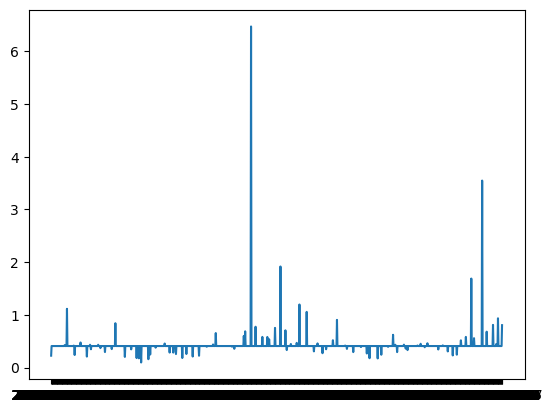

In [357]:
for product in products:
    for place in places:
        fig, ax = plt.subplots()
        ax.plot(df_product_place[product_dict[product]][place_dict[place]]["cost per unit"])

In [ ]:
# Проверка критерия Дики-Фуллера о нестационарности. Тест показал, что гипотезу о нестационарности следуют отвергнуть.
# В связи со стационарностью для затрат на производство единицы товара решено не строить прогнозную модель, 
# а принять ее в будщем постоянной, равной медиане

In [940]:
for product in products:
    for place in places:
        print("pvalue = " + str(adfuller(df_product_place[product_dict[product]][place_dict[place]]["cost per unit"])[1]))

pvalue = 0.0
pvalue = 2.0414901703622774e-05
pvalue = 0.00011807966068262786
pvalue = 3.4403631418507118e-06
pvalue = 0.005611324151475911
pvalue = 0.0
pvalue = 5.894621488193256e-05
pvalue = 0.0
pvalue = 4.073231139574015e-05
pvalue = 0.0
pvalue = 0.0
pvalue = 9.845478995258434e-07
pvalue = 4.730119488637086e-07
pvalue = 6.47161617173587e-05
pvalue = 0.0


In [ ]:
# Построение моделей prophet для предсказания средней цены конкурентов для каждого датасета

In [970]:
comp_price_forecast = [[] for product in products]
for product in products:
    for place in places:
        df = df_product_place[product_dict[product]][place_dict[place]].reset_index()
        model = Prophet(daily_seasonality = False)
        df_prophet = pd.DataFrame()
        df_prophet["ds"] = df["date"]
        df_prophet["y"] = df["avg comp price"].fillna(df.dropna()["avg comp price"].quantile(0.5))
        model.fit(df_prophet)
        future = model.make_future_dataframe(periods=90, freq='D')
        forecast = model.predict(future)
        comp_price_forecast[product_dict[product]].append(
            ((forecast.iloc[-90:]["yhat_lower"] + forecast.iloc[-90:]["yhat"]) / 2).reset_index().drop(
            "index", axis = 1))

04:14:25 - cmdstanpy - INFO - Chain [1] start processing
04:14:25 - cmdstanpy - INFO - Chain [1] done processing
04:14:25 - cmdstanpy - INFO - Chain [1] start processing
04:14:25 - cmdstanpy - INFO - Chain [1] done processing
04:14:26 - cmdstanpy - INFO - Chain [1] start processing
04:14:26 - cmdstanpy - INFO - Chain [1] done processing
04:14:26 - cmdstanpy - INFO - Chain [1] start processing
04:14:26 - cmdstanpy - INFO - Chain [1] done processing
04:14:27 - cmdstanpy - INFO - Chain [1] start processing
04:14:27 - cmdstanpy - INFO - Chain [1] done processing
04:14:27 - cmdstanpy - INFO - Chain [1] start processing
04:14:27 - cmdstanpy - INFO - Chain [1] done processing
04:14:27 - cmdstanpy - INFO - Chain [1] start processing
04:14:27 - cmdstanpy - INFO - Chain [1] done processing
04:14:28 - cmdstanpy - INFO - Chain [1] start processing
04:14:28 - cmdstanpy - INFO - Chain [1] done processing
04:14:28 - cmdstanpy - INFO - Chain [1] start processing
04:14:28 - cmdstanpy - INFO - Chain [1]

In [971]:
comp_price_forecast[0][0]

,0
0,14.006703
1,14.338703
2,14.042680
3,14.109615
4,14.134929
...,...
85,14.889743
86,14.626682
87,14.692294
88,14.719036


In [ ]:
# Пример построения модели prophet для товара "Целебные травы" и места "Анор Лондо"

In [941]:
df = df_product_place[product_dict["Целебные травы"]][place_dict["Анор Лондо"]].reset_index()
model = Prophet(daily_seasonality = False)
df_prophet = pd.DataFrame()
df_prophet["ds"] = df["date"]
df_prophet["y"] = df["avg comp price"].fillna(df.dropna()["avg comp price"].quantile(0.5))
model.fit(df_prophet)
future = model.make_future_dataframe(periods=90, freq='D')
forecast = model.predict(future)

03:45:59 - cmdstanpy - INFO - Chain [1] start processing
03:45:59 - cmdstanpy - INFO - Chain [1] done processing


In [962]:
(forecast["yhat"] + forecast["yhat_lower"]) / 2

0       12.968309
1       12.863901
2       12.831860
3       13.113139
4       12.985958
          ...    
1083    26.741517
1084    26.618639
1085    26.639762
1086    26.900340
1087    26.828008
Length: 1088, dtype: float64

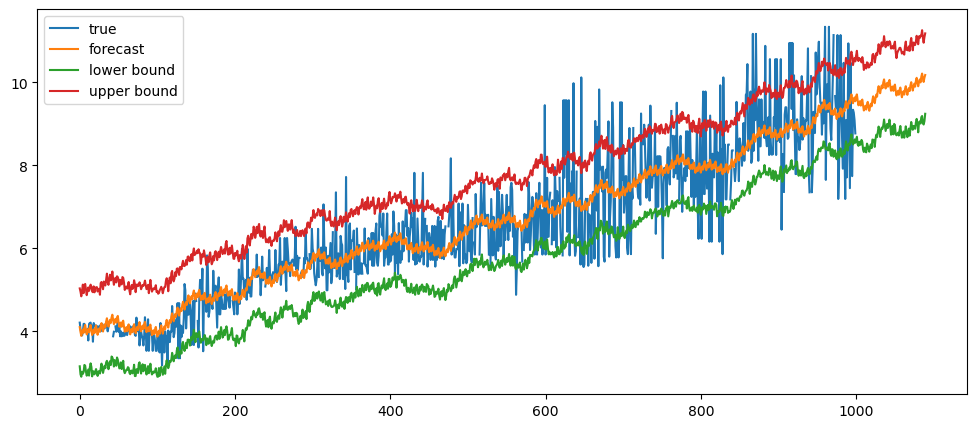

In [944]:
plt.plot(df["avg comp price"], label = "true")
plt.plot(forecast["yhat"], label = "forecast")
plt.plot(forecast["yhat_lower"], label = "lower bound")
plt.plot(forecast["yhat_upper"], label = "upper bound")
plt.legend()

In [ ]:
# Построение датасета для решения задачи квадратичной оптимизации
# В качестве прогнозных данных средняя цена у конкурентов, затраты на единицу товара, погодные условия, коэффициент линейной
# функции зависимости спроса от цены и ее свободный член

In [974]:
new_data = [[] for product in products]
for product in products:
    for place in places:
        row = pd.DataFrame(range(1, 91), columns = ["num days"])
        row["avg comp price"] = np.round(comp_price_forecast[product_dict[product]][place_dict[place]], 2)
        row["cost per unit"] = df_product_place[product_dict[product]][place_dict[place]]["cost per unit"].quantile(0.5)
        row["hot"] = df_product_place[product_dict[product]][place_dict[place]]["hot"].mean()
        row["rain"] = df_product_place[product_dict[product]][place_dict[place]]["rain"].mean()
        row["snow"] = df_product_place[product_dict[product]][place_dict[place]]["snow"].mean()
        row["intercept"] = row["hot"] * models[product_dict[product]][place_dict[place]].coef_[1] + row[
            "rain"] * models[product_dict[product]][place_dict[place]].coef_[2] + row[
    "snow"] * models[product_dict[product]][place_dict[place]].coef_[3] + (
            1000 + row["num days"]) * models[product_dict[product]][place_dict[place]].coef_[4] + np.cos((
    999 + row["num days"]) * 2 * np.pi / 500) * models[product_dict[product]][place_dict[place]].coef_[5] + models[
            product_dict[product]][place_dict[place]].intercept_
        row["coef"] = models[product_dict[product]][place_dict[place]].coef_[0]
        new_data[product_dict[product]].append(row)

In [ ]:
# Запись полученных датасетов с данными для решения оптимизационных задач в файлы excel

In [975]:
for product in products:
    for place in places:
        new_data[product_dict[product]][place_dict[place]].to_excel(str(product) + " " + str(place) + ".xlsx")

In [976]:
new_data[0][1]

,num days,avg comp price,cost per unit,hot,rain,snow,intercept,coef
0,1,9.80,0.071,0.182,0.156,0.175,85.319340,-4.190864
1,2,9.80,0.071,0.182,0.156,0.175,85.350223,-4.190864
2,3,9.83,0.071,0.182,0.156,0.175,85.381738,-4.190864
3,4,9.87,0.071,0.182,0.156,0.175,85.413888,-4.190864
4,5,9.76,0.071,0.182,0.156,0.175,85.446670,-4.190864
...,...,...,...,...,...,...,...,...
85,86,10.31,0.071,0.182,0.156,0.175,89.996434,-4.190864
86,87,10.35,0.071,0.182,0.156,0.175,90.071327,-4.190864
87,88,10.40,0.071,0.182,0.156,0.175,90.146518,-4.190864
88,89,10.28,0.071,0.182,0.156,0.175,90.222001,-4.190864


In [947]:
df_baseline = pd.read_parquet("df_baseline.parquet")
df_baseline.head()

,day_num,place,product,price
0,1,Анор Лондо,Целебные травы,13.63
1,2,Анор Лондо,Целебные травы,13.63
2,3,Анор Лондо,Целебные травы,13.63
3,4,Анор Лондо,Целебные травы,13.63
4,5,Анор Лондо,Целебные травы,13.63


In [948]:
baselines = [[] for product in products]
for product in products:
    for place in places:
        baselines[product_dict[product]].append(df_baseline[(df_baseline["product"] == product)&(
            df_baseline["place"] == place)].iloc[1]["price"])

In [952]:
pd.DataFrame(baselines).to_excel("baselines.xlsx")